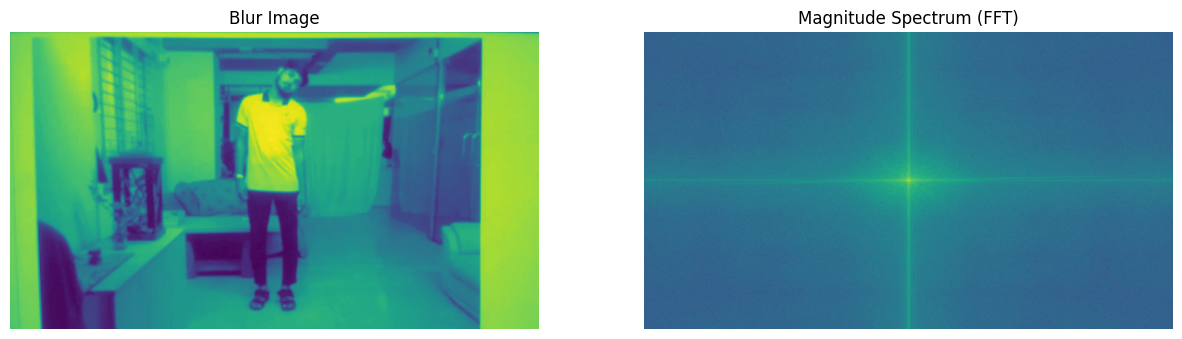

Blur Metric (Average Magnitude Spectrum): 122.21607660277179


In [54]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Load the image
image = cv2.imread(r"F:\Blurryness detection\sample_images\tilt_head_left.jpg", cv2.IMREAD_GRAYSCALE)

# Perform FFT on the image
fft_image = np.fft.fft2(image)
fft_shifted = np.fft.fftshift(fft_image)
magnitude_spectrum = 20 * np.log(np.abs(fft_shifted))

# Calculate the blur metric from FFT
blur_metric = np.mean(magnitude_spectrum)

# Plot original image and magnitude spectrum
plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Blur Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(magnitude_spectrum)
plt.title("Magnitude Spectrum (FFT)")
plt.axis("off")

plt.show()

print("Blur Metric (Average Magnitude Spectrum):", blur_metric)

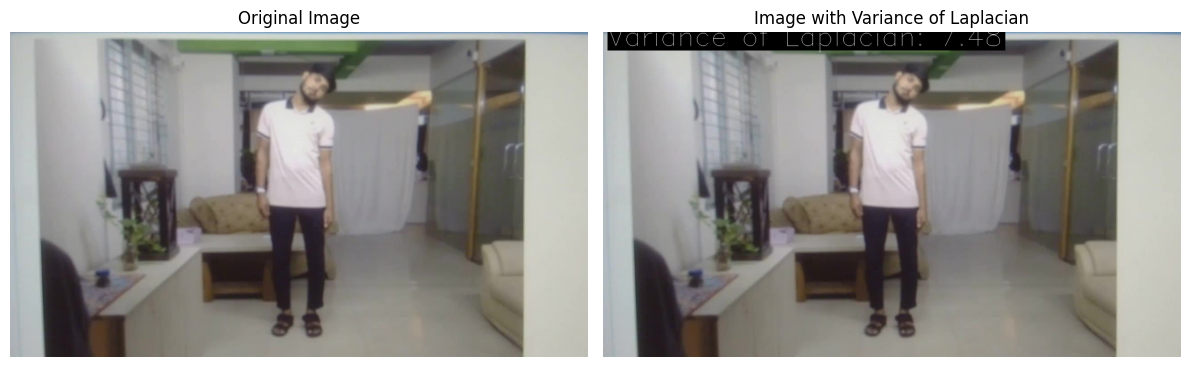

In [53]:
import cv2
import matplotlib.pyplot as plt

def variance_of_laplacian(image):
    """
    Compute the Laplacian of the image and return the focus measure.
    """
    return cv2.Laplacian(image, cv2.CV_64F).var()

def add_text_with_black_background(image, fm, position, font_scale=0.5, thickness=1.5):
    """
    Function to add the focus measure on the image.
    """
    text = 'Variance of Laplacian:'
    full_text = text + ' ' + str(round(fm, 2))
    (text_width, text_height), _ = cv2.getTextSize(full_text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)
    
    # Create a rectangle for text background
    cv2.rectangle(image, (position[0], position[1] - text_height - 10), 
                  (position[0] + text_width + 5, position[1] + 10), (0, 0, 0), cv2.FILLED)

    # Add text to the image
    cv2.putText(image, full_text, (position[0], position[1]), 
                cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), thickness)

# Path to the image
imagePath = r'F:\Blurryness detection\sample_images\tilt_head_left.jpg'  # Replace with your image path

# Read the image
image = cv2.imread(imagePath)

# Check if the image was loaded successfully
if image is None:
    print(f"Error: Could not read the image from {imagePath}")
else:
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Compute the focus measure
    fm = variance_of_laplacian(gray)

    # Position for the text
    position = (10, 30)

    # Create a copy of the original image for annotation
    annotated_image = image.copy()
    add_text_with_black_background(annotated_image, fm, position, font_scale=2, thickness=1)

    # Convert images from BGR to RGB for correct color display
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

    # Set up the subplot to show both images
    plt.figure(figsize=(12, 6))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb)  # Display the original image
    plt.title('Original Image')
    plt.axis('off')  # Hide axes

    # Image with Focus Measure
    plt.subplot(1, 2, 2)
    plt.imshow(annotated_image_rgb)  # Display the annotated image
    plt.title('Image with Variance of Laplacian')
    plt.axis('off')  # Hide axes

    # Show the plots
    plt.tight_layout()
    plt.show()


In [49]:
import cv2
import numpy as np
from scipy.fft import fft2, ifft2
from skimage.measure import EllipseModel

def detect_blur(image):
    # Split the image into R, G, B channels
    b, g, r = cv2.split(image)
    
    # Compute phase difference between R and B channels
    fr = fft2(r)
    fb = fft2(b)
    phase_diff = np.angle(fr) - np.angle(fb)
    
    # Compute psi as defined in the paper
    psi = np.maximum(1 - np.abs(phase_diff) / (np.pi/4), 0)
    
    # Threshold psi
    threshold = 0.5
    psi_thresh = (psi > threshold).astype(np.uint8)
    
    # Find contours and fit ellipse
    contours, _ = cv2.findContours(psi_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        ellipse = cv2.fitEllipse(largest_contour)
        
        # Calculate blur ratio (minor axis / major axis)
        (_, _), (minor_axis, major_axis), angle = ellipse
        blur_ratio = minor_axis / major_axis
        
        return blur_ratio, angle
    
    return None, None

def estimate_psf(angle, length):
    PSF = np.zeros((length, length))
    center = length // 2
    for i in range(length):
        offset = int(round(i * np.tan(np.radians(angle))))
        PSF[center + offset, i] = 1
    PSF /= np.sum(PSF)
    return PSF

def wiener_filter(image, psf, K):
    image_f = fft2(image)
    psf_f = fft2(psf, s=image.shape)
    psf_f_conj = np.conj(psf_f)
    result = ifft2(image_f * psf_f_conj / (np.abs(psf_f)**2 + K))
    return np.real(result)

def correct_blur(image, angle, blur_ratio):
    b, g, r = cv2.split(image)
    
    # Estimate blur kernel length
    kernel_length = int(min(image.shape) * (1 - blur_ratio))
    kernel_length = max(3, min(kernel_length, 21))  # Limit kernel size
    
    # Estimate PSF
    psf = estimate_psf(angle, kernel_length)
    
    # Apply Wiener deconvolution
    K = 0.01  # Regularization parameter, may need adjustment
    r_deconv = wiener_filter(r, psf, K)
    g_deconv = wiener_filter(g, psf, K)
    b_deconv = wiener_filter(b, psf, K)
    
    # Normalize and clip values
    r_deconv = np.clip(r_deconv, 0, 255).astype(np.uint8)
    g_deconv = np.clip(g_deconv, 0, 255).astype(np.uint8)
    b_deconv = np.clip(b_deconv, 0, 255).astype(np.uint8)
    
    # Blend with original image to reduce artifacts
    alpha = 0.7  # Adjust this value to control correction strength
    r_final = cv2.addWeighted(r, 1-alpha, r_deconv, alpha, 0)
    g_final = cv2.addWeighted(g, 1-alpha, g_deconv, alpha, 0)
    b_final = cv2.addWeighted(b, 1-alpha, b_deconv, alpha, 0)
    
    return cv2.merge([b_final, g_final, r_final])

def main():
    # Read the image
    image = cv2.imread(r'F:\Blurryness detection\sample_images\tilt_head_left.jpg')
    # image=cv2.resize(image,(512,512))
    print(image.shape)
    # Detect blur
    blur_ratio, angle = detect_blur(image)
    
    if blur_ratio is not None:
        print(f"Detected blur ratio: {blur_ratio:.2f}, angle: {angle:.2f}")
        
        if blur_ratio >= 0.35:
            # Small blur correction
            corrected_image = correct_blur(image, angle,blur_ratio)
        else:
            # Large blur correction (not implemented in this simplified version)
            print("Large blur detected. Advanced correction not implemented in this script.")
            corrected_image = image
        
        # Display results
        cv2.imshow('Original Image', image)
        cv2.imshow('Corrected Image', corrected_image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    else:
        print("No significant blur detected.")

if __name__ == "__main__":
    main()

(720, 1280, 3)
Detected blur ratio: 0.95, angle: 160.92


In [48]:
import cv2
import numpy as np
from skimage.restoration import unsupervised_wiener
from scipy.signal import convolve2d
from skimage import color

def detect_blur(image):
    # Split the image into R, G, B channels
    b, g, r = cv2.split(image)
    
    # Compute phase difference between R and B channels
    fr = np.fft.fft2(r)
    fb = np.fft.fft2(b)
    phase_diff = np.angle(fr) - np.angle(fb)
    
    # Refined computation for psi
    psi = np.maximum(1 - np.abs(phase_diff) / (np.pi / 6), 0)
    
    # Threshold psi
    threshold = 0.5
    psi_thresh = (psi > threshold).astype(np.uint8)
    
    # Find contours and fit ellipse
    contours, _ = cv2.findContours(psi_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        ellipse = cv2.fitEllipse(largest_contour)
        
        # Calculate blur ratio (minor axis / major axis)
        (_, _), (minor_axis, major_axis), angle = ellipse
        blur_ratio = minor_axis / major_axis
        
        return blur_ratio, angle
    
    return None, None

def estimate_initial_psf(length=15):
    psf = np.ones((length, length)) / (length * length)
    return psf

def blind_deconvolution(image, psf):
    deconvolved_image, _ = unsupervised_wiener(image, psf)
    return np.clip(deconvolved_image, 0, 1) * 255

def correct_blur(image):
    # Convert the image to grayscale for deconvolution
    gray_image = color.rgb2gray(image / 255.0)

    # Estimate an initial PSF (small size for robustness)
    psf = estimate_initial_psf(length=15)

    # Perform blind deconvolution using unsupervised Wiener filter
    corrected_image = blind_deconvolution(gray_image, psf)

    # Convert back to a 3-channel image to match the input format
    corrected_image_colored = cv2.cvtColor(corrected_image.astype(np.uint8), cv2.COLOR_GRAY2BGR)
    return corrected_image_colored

def main():
    # Read the image
    image = cv2.imread(r'F:\Blurryness detection\sample_images\tilt_head_left.jpg')
    
    # Detect blur
    blur_ratio, angle = detect_blur(image)
    
    if blur_ratio is not None:
        print(f"Detected blur ratio: {blur_ratio:.2f}, angle: {angle:.2f}")
        
        # Use blind deconvolution for correction
        corrected_image = correct_blur(image)
        
        # Display results
        cv2.imshow('Original Image', image)
        cv2.imshow('Corrected Image', corrected_image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    else:
        print("No significant blur detected.")

if __name__ == "__main__":
    main()


Detected blur ratio: 0.79, angle: 165.20


In [37]:
import cv2
import numpy as np
from skimage.restoration import richardson_lucy

def detect_blur(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    laplacian_var = cv2.Laplacian(gray_image, cv2.CV_64F).var()
    print(f"Laplacian Variance: {laplacian_var}")  # Debug info

    # A lower variance means more blur; adjust this threshold as needed
    threshold = 150.0  
    return laplacian_var < threshold

def estimate_psf(length=15, angle=0):
    psf = np.zeros((length, length))
    center = length // 2
    for i in range(length):
        offset = int(round(np.tan(np.radians(angle)) * (i - center)))
        if 0 <= center + offset < length:
            psf[center + offset, i] = 1
    psf /= psf.sum()
    return psf

def apply_richardson_lucy(image, psf, iterations=10):
    image = image.astype(np.float64) / 255.0  # Normalize to [0, 1] range
    result = np.zeros_like(image)

    for channel in range(3):  # Apply to each color channel separately
        result[..., channel] = richardson_lucy(image[..., channel], psf, iterations=iterations)

    return np.clip(result * 255, 0, 255).astype(np.uint8)

def correct_blur(image, psf_length=15, psf_angle=0):
    psf = estimate_psf(length=psf_length, angle=psf_angle)
    corrected_image = apply_richardson_lucy(image, psf, iterations=15)
    return corrected_image

def main():
    # Read the image
    image = cv2.imread('sample_images/sssss.png')

    # Check for blur detection
    is_blur = detect_blur(image)
    
    if is_blur:
        print("Blur detected. Applying deblurring algorithm.")
        corrected_image = correct_blur(image, psf_length=15, psf_angle=0)
        
        # Display results
        cv2.imshow('Original Image', image)
        cv2.imshow('Deblurred Image', corrected_image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    else:
        print("No significant blur detected.")

if __name__ == "__main__":
    main()


Laplacian Variance: 330.4575545569572
No significant blur detected.
